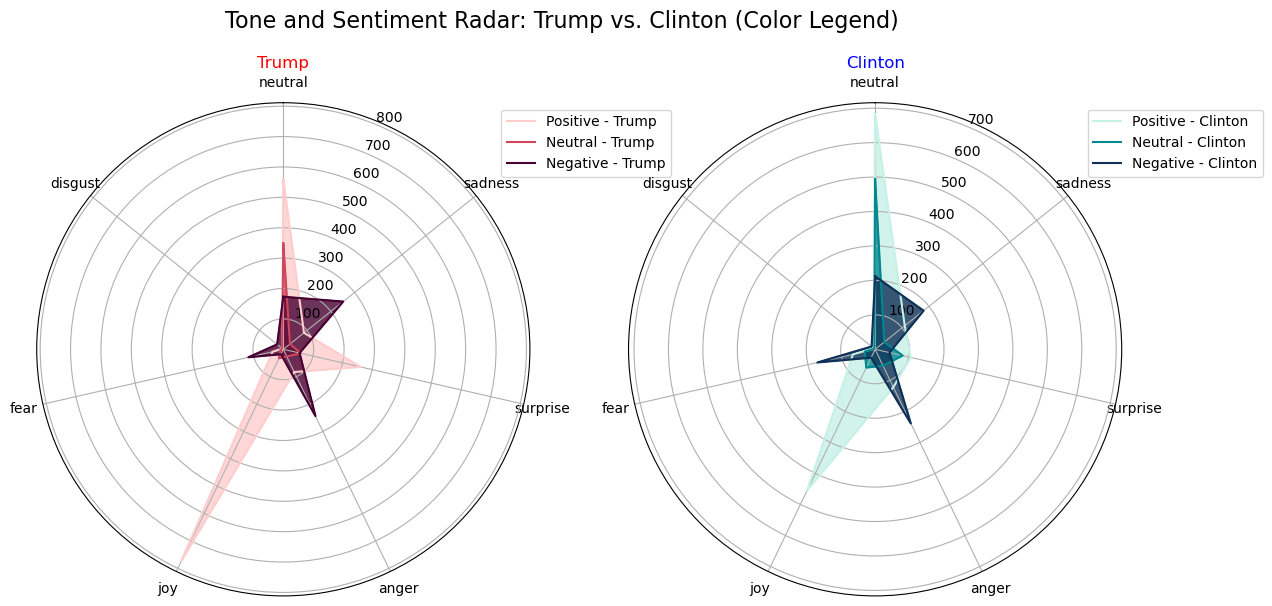

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
file_path = 'FinalVersionV2.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')

# Filter data for Trump and Clinton
data_trump = data[data['handle'] == 'realDonaldTrump']
data_clinton = data[data['handle'] == 'HillaryClinton']

# Define tones and calculate frequency of each tone for Trump and Clinton
tones = data['tone'].unique()
tone_counts_trump = data_trump['tone'].value_counts().reindex(tones, fill_value=0).values
tone_counts_clinton = data_clinton['tone'].value_counts().reindex(tones, fill_value=0).values

# Define custom colors for sentiments based on user input
custom_colors_trump = {
    'neutral': '#cf455c',  # Medium red for neutral
    'positive': '#ffcdcd',  # Light red for positive
    'negative': '#470031'   # Dark burgundy for negative
}

custom_colors_clinton = {
    'neutral': '#008891',   # Medium teal for neutral
    'positive': '#c6f1e7',  # Light mint green for positive
    'negative': '#0f3057'   # Dark blue for negative
}

# Calculate sentiment-specific tone frequencies
sentiments = ['neutral', 'positive', 'negative']
sentiment_freq_trump = {
    sentiment: data_trump[data_trump['semtiment'] == sentiment]['tone'].value_counts().reindex(tones, fill_value=0).values
    for sentiment in sentiments
}
sentiment_freq_clinton = {
    sentiment: data_clinton[data_clinton['semtiment'] == sentiment]['tone'].value_counts().reindex(tones, fill_value=0).values
    for sentiment in sentiments
}

# Generate angles for radar plot
angles = np.linspace(0, 2 * np.pi, len(tones), endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Plot radar charts with descriptions for both Trump and Clinton
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), subplot_kw=dict(polar=True))
fig.suptitle("Tone and Sentiment Radar: Trump vs. Clinton (Color Legend)", fontsize=16)

# Trump Radar Plot
ax1.set_theta_offset(np.pi / 2)
ax1.set_theta_direction(-1)
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(tones)

for sentiment in ['positive', 'neutral', 'negative']:
    color = custom_colors_trump[sentiment]
    freq_values = np.append(sentiment_freq_trump[sentiment], sentiment_freq_trump[sentiment][0])  # Close loop
    ax1.plot(angles, freq_values, color=color, linewidth=1.5, label=f'{sentiment.capitalize()} - Trump')
    ax1.fill(angles, freq_values, color=color, alpha=0.8)  # 80% opacity for visibility
ax1.set_title("Trump", color="red")
ax1.legend(loc="upper right", bbox_to_anchor=(1.3, 1))

# Clinton Radar Plot
ax2.set_theta_offset(np.pi / 2)
ax2.set_theta_direction(-1)
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(tones)

for sentiment in ['positive', 'neutral', 'negative']:
    color = custom_colors_clinton[sentiment]
    freq_values = np.append(sentiment_freq_clinton[sentiment], sentiment_freq_clinton[sentiment][0])  # Close loop
    ax2.plot(angles, freq_values, color=color, linewidth=1.5, label=f'{sentiment.capitalize()} - Clinton')
    ax2.fill(angles, freq_values, color=color, alpha=0.8)  # 80% opacity for visibility
ax2.set_title("Clinton", color="blue")
ax2.legend(loc="upper right", bbox_to_anchor=(1.3, 1))

# Display the plots
plt.show()

In [2]:
import pandas as pd
import plotly.graph_objects as go

# Extract unique values for topics, handles, and sentiments
topics = data['topics'].unique().tolist()
handles = ['realDonaldTrump', 'HillaryClinton']
sentiments = data['semtiment'].unique().tolist()

# Combine all nodes and assign positions
all_nodes = topics + handles + sentiments
node_positions = {name: idx for idx, name in enumerate(all_nodes)}

# Create links between topic -> handle and handle -> sentiment with count values
links = []
for topic in topics:
    for handle in handles:
        count = len(data[(data['topics'] == topic) & (data['handle'] == handle)])
        if count > 0:
            links.append({
                'source': node_positions[topic],
                'target': node_positions[handle],
                'value': count,
                'color': '#B21D1D' if handle == 'realDonaldTrump' else '#260C65'
            })

for handle in handles:
    for sentiment in sentiments:
        count = len(data[(data['handle'] == handle) & (data['semtiment'] == sentiment)])
        if count > 0:
            links.append({
                'source': node_positions[handle],
                'target': node_positions[sentiment],
                'value': count,
                'color': '#B21D1D' if handle == 'realDonaldTrump' else '#260C65'
            })

# Assign node colors: white for handles, light gray for other nodes
node_colors = ['#cccccc'] * len(all_nodes)  # Default light color for topics and sentiments
node_colors[node_positions['realDonaldTrump']] = '#ffffff'  # White for Trump handle
node_colors[node_positions['HillaryClinton']] = '#ffffff'  # White for Clinton handle

# Define Sankey diagram data with customized empty rectangular nodes
sankey_data = go.Sankey(
    node=dict(
        pad=15,
        thickness=10,
        line=dict(color="black", width=0.5),  # Black border for clarity
        label=all_nodes,
        color=node_colors,
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links],
        color=[link['color'] for link in links]
    )
)

# Generate and display the Sankey Diagram with customized layout
fig = go.Figure(data=[sankey_data])
fig.update_layout(
    title_text="Sankey Diagram: Topics -> Handle -> Sentiment",
    font_size=10,
    plot_bgcolor='rgba(255,255,255,1)',
    margin=dict(l=100, r=100, t=50, b=50)
)
fig.show()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import plotly.graph_objects as go

# 获取唯一的过滤条件
unique_topics = data['topics'].unique().tolist()
unique_handles = data['handle'].unique().tolist()
unique_sentiments = data['semtiment'].unique().tolist()

# 过滤数据的通用函数
def filter_data(data, topic=None, handle=None, sentiment=None):
    filters = {}
    if topic:
        filters['topics'] = topic
    if handle:
        filters['handle'] = handle
    if sentiment:
        filters['semtiment'] = sentiment
    return data.loc[(data[list(filters)] == pd.Series(filters)).all(axis=1)]

# 绘制雷达图的通用设置
def configure_radar_plot(ax, angles, tones, title, color):
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(tones)
    ax.set_title(title, color=color)

# 绘制雷达图
def plot_filtered_radar_chart(data, topic=None, handle=None, sentiment=None):
    filtered_data = filter_data(data, topic, handle, sentiment)
    tones = filtered_data['tone'].unique()
    angles = np.linspace(0, 2 * np.pi, len(tones), endpoint=False).tolist() + [0]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), subplot_kw=dict(polar=True))
    fig.suptitle("Filtered Tone and Sentiment Radar: Trump vs. Clinton", fontsize=16)

    # 定义颜色
    custom_colors = {
        'Trump': {'neutral': '#cf455c', 'positive': '#ffcdcd', 'negative': '#470031'},
        'Clinton': {'neutral': '#008891', 'positive': '#c6f1e7', 'negative': '#0f3057'}
    }

    for ax, name, color, custom_colors_set in zip(
        [ax1, ax2], ['Trump', 'Clinton'], ['red', 'blue'], [custom_colors['Trump'], custom_colors['Clinton']]
    ):
        filtered_name = filtered_data[filtered_data['handle'] == f'realDonald{name}']
        tone_counts = filtered_name['tone'].value_counts().reindex(tones, fill_value=0).values

        configure_radar_plot(ax, angles, tones, name, color)
        for sentiment, fill_color in custom_colors_set.items():
            freq_values = np.append(tone_counts, tone_counts[0])
            ax.plot(angles, freq_values, color=fill_color, linewidth=1.5, label=f'{sentiment.capitalize()} - {name}')
            ax.fill(angles, freq_values, color=fill_color, alpha=0.8)

        ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))

    plt.show()

# 绘制桑基图
def plot_filtered_sankey_chart(data, topic=None, handle=None, sentiment=None):
    filtered_data = filter_data(data, topic, handle, sentiment)
    nodes, links = {}, []

    # 创建节点和连接
    for col in ['topics', 'handle', 'semtiment']:
        nodes.update({name: idx for idx, name in enumerate(filtered_data[col].unique())})
    for source, target_col in [('topics', 'handle'), ('handle', 'semtiment')]:
        for source_val, target_val in filtered_data.groupby([source, target_col]).size().index:
            links.append({
                'source': nodes[source_val],
                'target': nodes[target_val],
                'value': filtered_data[(filtered_data[source] == source_val) & (filtered_data[target_col] == target_val)].shape[0],
                'color': '#B21D1D' if 'Trump' in target_val else '#260C65'
            })

    # 颜色设置
    node_colors = ['#cccccc'] * len(nodes)
    for handle in ['realDonaldTrump', 'HillaryClinton']:
        if handle in nodes:
            node_colors[nodes[handle]] = '#ffffff'

    sankey_data = go.Sankey(
        node=dict(pad=15, thickness=10, line=dict(color="black", width=0.5), label=list(nodes.keys()), color=node_colors),
        link=dict(source=[link['source'] for link in links], target=[link['target'] for link in links], value=[link['value'] for link in links], color=[link['color'] for link in links])
    )

    fig = go.Figure(data=[sankey_data])
    fig.update_layout(title_text="Filtered Sankey Diagram", font_size=10, plot_bgcolor='rgba(255,255,255,1)', margin=dict(l=100, r=100, t=50, b=50))
    fig.show()

# 选择和过滤选项的交互
interact(lambda chart_type, topic, handle, sentiment: plot_filtered_radar_chart(data, topic, handle, sentiment) if chart_type == "Radar Chart" else plot_filtered_sankey_chart(data, topic, handle, sentiment),
         chart_type=widgets.ToggleButtons(options=["Radar Chart", "Sankey Chart"], description="Select Chart:"),
         topic=widgets.Dropdown(options=[None] + unique_topics, description="Topic:"),
         handle=widgets.Dropdown(options=[None] + unique_handles, description="Handle:"),
         sentiment=widgets.Dropdown(options=[None] + unique_sentiments, description="Sentiment:"))

interactive(children=(ToggleButtons(description='Select Chart:', options=('Radar Chart', 'Sankey Chart'), valu…

<function __main__.<lambda>(chart_type, topic, handle, sentiment)>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import plotly.graph_objects as go



# 获取唯一的过滤条件
unique_topics = data['topics'].unique().tolist()
unique_handles = data['handle'].unique().tolist()
unique_sentiments = data['semtiment'].unique().tolist()

# 过滤后的雷达图
def plot_filtered_radar_chart(topic=None, handle=None, sentiment=None):
    filtered_data = data.copy()
    if topic: filtered_data = filtered_data[filtered_data['topics'] == topic]
    if handle: filtered_data = filtered_data[filtered_data['handle'] == handle]
    if sentiment: filtered_data = filtered_data[filtered_data['semtiment'] == sentiment]

    tones = filtered_data['tone'].unique()
    filtered_trump = filtered_data[filtered_data['handle'] == 'realDonaldTrump']
    filtered_clinton = filtered_data[filtered_data['handle'] == 'HillaryClinton']
    
    tone_counts_trump = filtered_trump['tone'].value_counts().reindex(tones, fill_value=0).values
    tone_counts_clinton = filtered_clinton['tone'].value_counts().reindex(tones, fill_value=0).values
    
    custom_colors_trump = {'neutral': '#cf455c', 'positive': '#ffcdcd', 'negative': '#470031'}
    custom_colors_clinton = {'neutral': '#008891', 'positive': '#c6f1e7', 'negative': '#0f3057'}
    
    sentiments = ['neutral', 'positive', 'negative']
    angles = np.linspace(0, 2 * np.pi, len(tones), endpoint=False).tolist()
    angles += angles[:1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), subplot_kw=dict(polar=True))
    fig.suptitle("Filtered Tone and Sentiment Radar: Trump vs. Clinton", fontsize=16)

    # Trump
    ax1.set_theta_offset(np.pi / 2)
    ax1.set_theta_direction(-1)
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(tones)

    for sentiment in sentiments:
        color = custom_colors_trump[sentiment]
        freq_values = np.append(tone_counts_trump, tone_counts_trump[0])
        ax1.plot(angles, freq_values, color=color, linewidth=1.5, label=f'{sentiment.capitalize()} - Trump')
        ax1.fill(angles, freq_values, color=color, alpha=0.8)
    ax1.set_title("Trump", color="red")
    ax1.legend(loc="upper right", bbox_to_anchor=(1.3, 1))

    # Clinton
    ax2.set_theta_offset(np.pi / 2)
    ax2.set_theta_direction(-1)
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(tones)

    for sentiment in sentiments:
        color = custom_colors_clinton[sentiment]
        freq_values = np.append(tone_counts_clinton, tone_counts_clinton[0])
        ax2.plot(angles, freq_values, color=color, linewidth=1.5, label=f'{sentiment.capitalize()} - Clinton')
        ax2.fill(angles, freq_values, color=color, alpha=0.8)
    ax2.set_title("Clinton", color="blue")
    ax2.legend(loc="upper right", bbox_to_anchor=(1.3, 1))

    plt.show()

# 过滤后的桑基图
def plot_filtered_sankey_chart(topic=None, handle=None, sentiment=None):
    filtered_data = data.copy()
    if topic: filtered_data = filtered_data[filtered_data['topics'] == topic]
    if handle: filtered_data = filtered_data[filtered_data['handle'] == handle]
    if sentiment: filtered_data = filtered_data[filtered_data['semtiment'] == sentiment]
    
    topics = filtered_data['topics'].unique().tolist()
    handles = filtered_data['handle'].unique().tolist()
    sentiments = filtered_data['semtiment'].unique().tolist()
    
    all_nodes = topics + handles + sentiments
    node_positions = {name: idx for idx, name in enumerate(all_nodes)}
    
    links = []
    for topic in topics:
        for handle in handles:
            count = len(filtered_data[(filtered_data['topics'] == topic) & (filtered_data['handle'] == handle)])
            if count > 0:
                links.append({
                    'source': node_positions[topic],
                    'target': node_positions[handle],
                    'value': count,
                    'color': '#B21D1D' if handle == 'realDonaldTrump' else '#260C65'
                })
    for handle in handles:
        for sentiment in sentiments:
            count = len(filtered_data[(filtered_data['handle'] == handle) & (filtered_data['semtiment'] == sentiment)])
            if count > 0:
                links.append({
                    'source': node_positions[handle],
                    'target': node_positions[sentiment],
                    'value': count,
                    'color': '#B21D1D' if handle == 'realDonaldTrump' else '#260C65'
                })

    node_colors = ['#cccccc'] * len(all_nodes)
    if 'realDonaldTrump' in handles:
        node_colors[node_positions['realDonaldTrump']] = '#ffffff'
    if 'HillaryClinton' in handles:
        node_colors[node_positions['HillaryClinton']] = '#ffffff'

    sankey_data = go.Sankey(
        node=dict(pad=15, thickness=10, line=dict(color="black", width=0.5), label=all_nodes, color=node_colors),
        link=dict(source=[link['source'] for link in links], target=[link['target'] for link in links], value=[link['value'] for link in links], color=[link['color'] for link in links])
    )

    fig = go.Figure(data=[sankey_data])
    fig.update_layout(title_text="Filtered Sankey Diagram", font_size=10, plot_bgcolor='rgba(255,255,255,1)', margin=dict(l=100, r=100, t=50, b=50))
    fig.show()

# 使用 ipywidgets 实现图表选择和过滤选项
interact(lambda chart_type, topic, handle, sentiment: plot_filtered_radar_chart(topic, handle, sentiment) if chart_type == "Radar Chart" else plot_filtered_sankey_chart(topic, handle, sentiment),
         chart_type=widgets.ToggleButtons(options=["Radar Chart", "Sankey Chart"], description="Select Chart:"),
         topic=widgets.Dropdown(options=[None] + unique_topics, description="Topic:"),
         handle=widgets.Dropdown(options=[None] + unique_handles, description="Handle:"),
         sentiment=widgets.Dropdown(options=[None] + unique_sentiments, description="Sentiment:"))

interactive(children=(ToggleButtons(description='Select Chart:', options=('Radar Chart', 'Sankey Chart'), valu…

<function __main__.<lambda>(chart_type, topic, handle, sentiment)>